In [1]:
from jacobi.complex_step import jacobi as cjac
from jacobi.real_step import forward, central
import numpy as np
from matplotlib import pyplot as plt

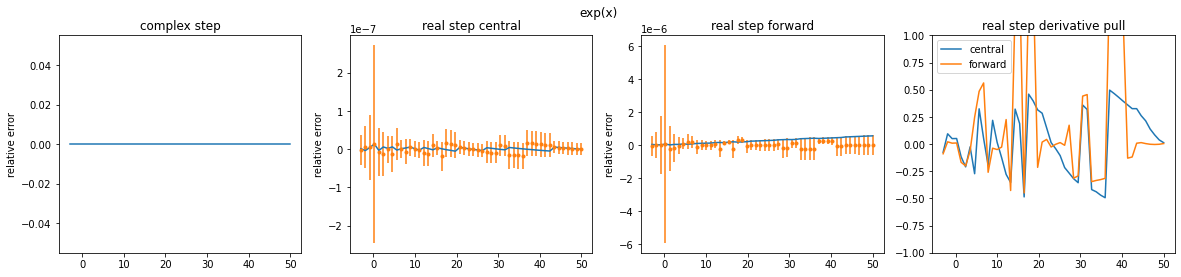

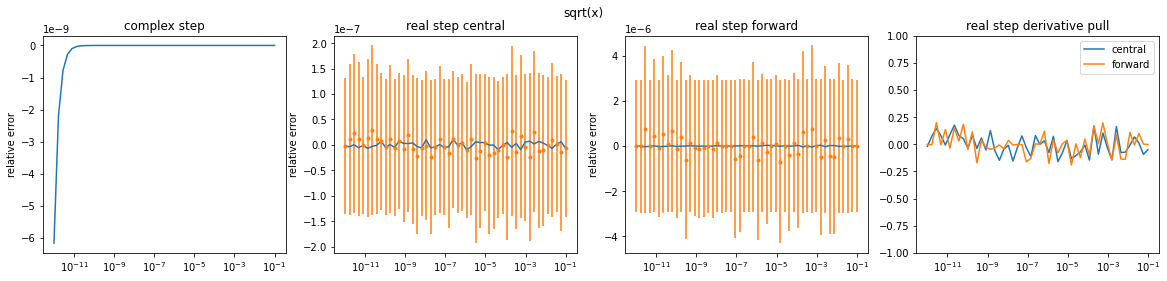

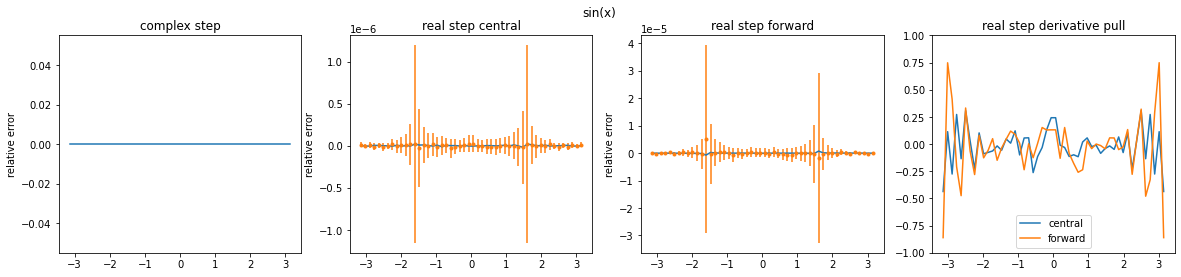

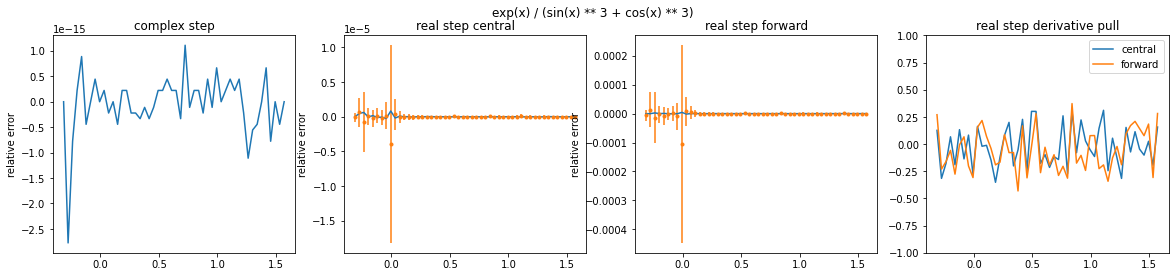

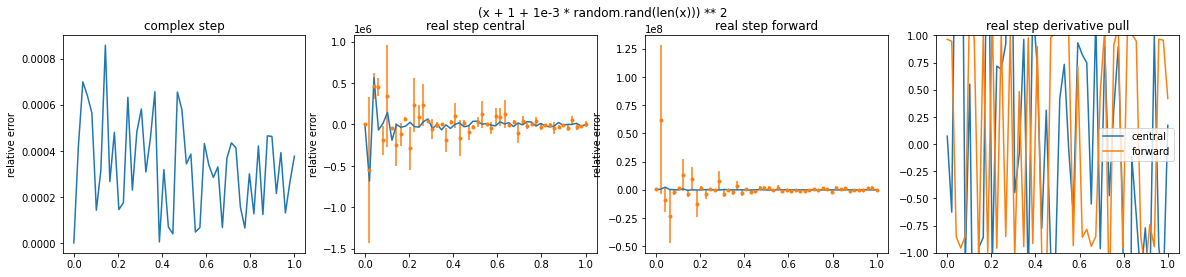

In [27]:
for x, fs, df in (
    (np.linspace(-3, 50), "exp(x)", np.exp),
    (np.geomspace(1e-12, 0.1), "sqrt(x)", lambda x: 0.5 / np.sqrt(x)),
    (np.linspace(-1, 1) * np.pi, "sin(x)", np.cos),
    (np.linspace(-0.1, 0.5) * np.pi, "exp(x) / (sin(x) ** 3 + cos(x) ** 3)", 
     lambda x: 0.5 * np.exp(x) * (3 * np.sin(x) + np.sin(3 * x) + 2 * np.cos(3 * x)) / (np.sin(x) ** 3 + np.cos(x) ** 3) ** 2),
    (np.linspace(0, 1), "(x + 1 + 1e-3 * random.rand(len(x))) ** 2", lambda x: 2 * (x + 1))
):
    f = eval("lambda x:" + fs, np.__dict__)
    y = f(x)
    dy0 = df(x)
    dy1 = cjac(f, x)
    dy2 = central(f, x, None, False)
    dy3, dy3e = central(f, x, None, True)
    dy4 = forward(f, x, None, False)
    dy5, dy5e = forward(f, x, None, True)

    fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
    fig.suptitle(fs)
    if np.all(x > 0) and x[-1] / x[0] > 1e3:
        plt.semilogx()
    ax[0].set_title("complex step")
    ax[0].plot(x, dy1/ dy0 - 1, zorder=1)
    ax[0].set_ylabel("relative error")
    ax[1].set_title("real step central")
    ax[1].plot(x, dy2/ dy0 - 1, "-", zorder=2)
    ax[1].errorbar(x, dy3/ dy0 - 1, dy3e / dy0, fmt=".", zorder=2)
    ax[1].set_ylabel("relative error")
    ax[2].set_title("real step forward")
    ax[2].plot(x, dy4/ dy0 - 1, "-", zorder=2)
    ax[2].errorbar(x, dy5/ dy0 - 1, dy5e / dy0, fmt=".", zorder=2)
    ax[2].set_ylabel("relative error")
    ax[3].set_title("real step derivative pull")
    ax[3].plot(x, (dy3 - dy0) / dy3e, label="central")
    ax[3].plot(x, (dy5 - dy0) / dy5e, label="forward")
    ax[3].legend()
    ax[3].set_ylim(-1, 1)

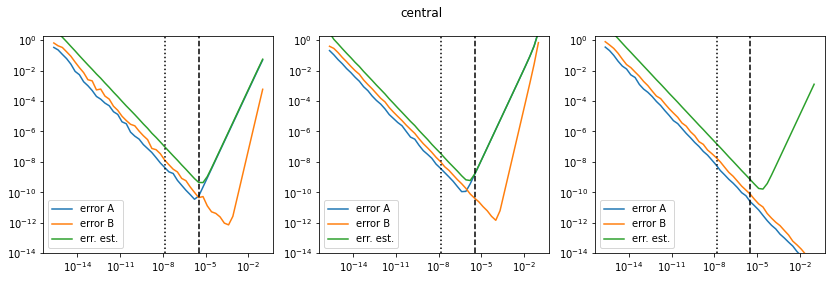

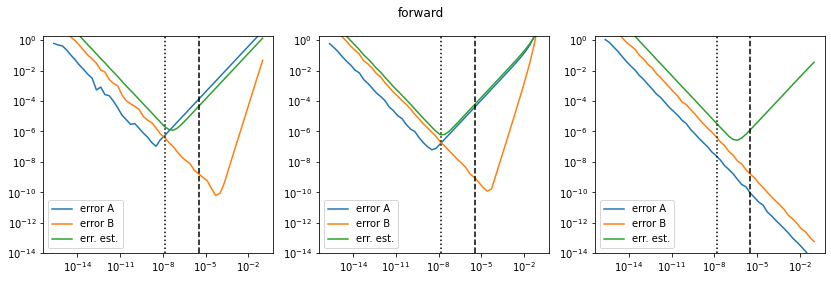

In [9]:
from jacobi.real_step import central, forward
eps = np.finfo(float).eps

h = np.geomspace(eps, 0.1)

for deriv in (central, forward):

    fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
    plt.suptitle(deriv.__name__)
    for axi, f, df, x in (
        (ax[0], np.sin, np.cos, np.linspace(-10, 10)),
        (ax[1], np.exp, np.exp, np.linspace(-5, 50)),
        (ax[2], np.sqrt, lambda x: 0.5 * x ** -0.5, np.geomspace(1e-10, 1)),
    ):
        dy0 = df(x)
        s1 = np.vectorize(lambda h: np.nanstd(deriv(f, x, np.abs(h * x)) / dy0))(h)
        s2 = np.vectorize(lambda h: np.nanstd(deriv(f, x, np.abs(h * x), True)[0] / dy0))(h)
        se = np.vectorize(lambda h: np.nanmean(deriv(f, x, np.abs(h * x), True)[1] / np.abs(dy0)))(h)

        plt.sca(axi)
        plt.plot(h, s1, label="error A")
        plt.plot(h, s2, label="error B")
        plt.plot(h, se, label="err. est.")
        plt.legend()

        plt.axvline(eps ** 0.5, ls=":", color="k")
        plt.axvline(eps ** 0.35, ls="--", color="k")
        plt.ylim(1e-14, 2)
        plt.loglog();